# Validation of the compound flood model
## Evaluating flood extent using EO-based flood maps 

This notebook focuses on the evaluation of flood maps obtained using the compound flood modelling workflow of COMPASS.  
In order to evaluate the quality of the model schematization, we compare the model results for the **factual scenario** against flood maps derived from Earth Observation (EO).

EO flood maps provide information on the observed flood extent and do not contain information on the flood depth. Therefore the comparison is focused on the flood extent.

Depending on the method of extracting flood maps from satellite data, the EO-derived flood map contours can look very different. This can be e.g. due to different thresholds being used to defined flooded areas or to the timing and temporal aggregation of the data. This also means that EO-based flood maps should not be treated as accurate observations but as one of the sources to assess flood extent.

### Validation using satellite-deived flood maps

Multiple sources of EO-based flood maps are available, for example:
- [UNOSAT](https://unosat.org/products/) 
- [CEMS](https://portal.gfm.eodc.eu/products) 
- [Global Flood Database](https://global-flood-database.cloudtostreet.ai/) 

[UNOSAT](https://unosat.org/products/) database contains flood maps for major flood events. This includes both satellite-derived maps from specific dates and aggregated maps for multi-day periods. It can include flood maps from various sources (e.g. Sentinel-1, VIIRS).

[CEMS](https://portal.gfm.eodc.eu/products) portal allows the user to download available flood map data for a given area (bounding box) and time. Maximum flood extent maps over the selected period are also available, these are user-friendly (single file instead of a tiled image) and suitable for comparison with maximum flood extent maps from flood modelling.

[Global Flood Database](https://global-flood-database.cloudtostreet.ai/) contains a database of mapped floods, this database only spans the period 2000-2018.

#### Other sources

When no EO flood maps are available or their quality is insufficient, alternative sources of data are necessary. These can be for example:  
- Reports by humanitarian aid organizations  
- Reports by public authorities  
- News articles mentioning specific flooded areas, social media etc.  

for example, for the Kenneth tropical cyclone in Northern Mozambique the EO-based sources above did not yield a flood map for comparison. Some indications of areas at high risk of flooding are indicated in the [briefing note by ACAPS](https://www.acaps.org/fileadmin/Data_Product/Main_media/20190429_acaps_start_briefing_note_mozambique_cyclone_kenneth.pdf).

### Example validation

For Idai (2019) flooding in Sofala, Mozambique maps are [available from UNOSAT](https://unosat.org/products/2715) and from CEMS. Both are derived from Sentinel-1 observations.

For Freddy (2023) flooding in Quelimane, Mozambique maps are [available from UNOSAT](https://unosat.org/products/3545). Flood maps are available based on mutiple different sources, including Sentinel-1, Sentinel-2 and VIIRS. In the CEMS database no flood maps are available for this event. 

For Iota (2020) flooding in Honduras, maps are [available from UNOSAT](https://unosat.org/products/2990), from Sentinel-1 and NOAA.


Below an example is given comparing the flood extents for several cyclones. In the cell below one can select which cyclone to focus on:

In [ ]:
event = 'idai' #'freddy', 'iota'

Then the python libraries need to be imported. For this notebook we are using the same Python environment that is used to perform flood map calculations in the COMPASS compound flood modelling workflow (`compass-wflow`).

In [3]:
from skill import skill #source: @DirkEilander, https://github.com/DirkEilander/compound_flood_modelling , Nov 2022
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from string import ascii_lowercase as abcd
import hydromt
import rioxarray as rxr
import rasterio as rio
from rasterio import features
from rasterio.features import sieve
from rasterio.crs import CRS
import geopandas as gpd

Setting main paths to the EO flood maps and flood map results from models.

In [4]:
dir_obs_unosat = r'p:\11210471-001-compass\01_Data\Validation_UNOSAT'
dir_obs_cems = r'p:\11210471-001-compass\01_Data\Validation_GFM'

rundirs = r'p:\11210471-001-compass\03_Runs'

Then the paths to the specific vector datasets of EO-based flood maps are set, as well as paths to the folders containing the model results. Information on CRS and UTM coordinate systems of the SFINCS model runs is needed to correctly convert the raster flood maps to the same coordinate system as the EO flood maps (this can also be automated).

In [5]:
if event == 'idai':
    mdir = join(rundirs, 'sofala\Idai\sfincs\event_tp_era5_hourly_zarr_CF0_GTSMv41opendap_CF-0.14_spw_IBTrACS_CF0')
    #file_floodmap_unosat = join(dir_obs_unosat, 'TC20190312MOZ_SHP\ST1_20190319_WaterExtent_SofalaProvince.shp')
    file_floodmap_unosat = join(dir_obs_unosat, 'TC20190312MOZ_SHP\ST1_20190319_WaterExtent_ManicaSofalaProvinces.shp')
    file_floodmap_cems = join(dir_obs_cems, 'Idai_2019\maximum_2019_03\maximum_flood_extent_2019-03-01_2019-03-30_beira_2025_06_26T11_41_09_531327.geojson')
    sfincs_crs = '32736'
    sfincs_utm = '36S'
elif event == 'freddy':
    mdir = join(rundirs, 'test\Freddy\sfincs\event_tp_era5_hourly_CF0_GTSMv41opendap_CF0_no_wind_CF0')
    file_floodmap_unosat = join(dir_obs_unosat, 'TC20230221MOZ_shp\VIIRS_20230315_20230319_Mozambique_FloodExtent.shp')
    file_floodmap_cems = None
    sfincs_crs = '32737'
    sfincs_utm = '36S'    
elif event == 'Iota':
    mdir = join(rundirs, 'honduras\EtaIota\sfincs\event_tp_era5_hourly_CF0_GTSMv41opendap_CF0_no_wind_CF0')
    file_floodmap_unosat = join(dir_obs_unosat, r'TC20201116HND_SHP\NOAA_20201113_20201117_FloodExtent_Honduras.shp')
    file_floodmap_cems = None
    sfincs_crs = '32616'
    sfincs_utm = '16p'       

We also need to set the flood depth threshold for the SFINCS model data to compare flood extents. By default we can set `hmin=0.2` i.e. 20 cm as the threshold to derive flood extent.

In [6]:
hmin=0.2

We will need to access datasets such as the permanent water mask from the Data Catalog, the link is given below:

In [7]:
dataCat = hydromt.data_catalog.DataCatalog(join('..', '..','..', 'Workflows', "03_data_catalogs", "datacatalog_general.yml"))

#### Load model data output

We can load the maximum water depth map that was postprocessed to the subgrid level as part of the workflow. We also need to access dataset of the permanent water mask to mask out rivers and sea from the flood maps (both model and EO-based) and access the polygon describing the model region.

In [8]:
# Read model output data 
da_model = rxr.open_rasterio(join(mdir,'plot_output','floodmap.tif'))

In [9]:
# add crs information and convert to rioxarray dataset
da_model = da_model.sortby(["x", "y"])
da_model.rio.write_crs(f"epsg:{sfincs_crs}", inplace=True)
ds = da_model.to_dataset(name='model')

In [10]:
# read region mask
region = gpd.read_file(join(mdir,'gis','region.geojson'))

In [11]:
# read permanent water mask
gswo = dataCat.get_rasterdataset("gswo", geom=region, buffer=1000)
gswo_mask = gswo.raster.reproject_like(da_model, method="max")

# permanent water where water occurence > 5%
ds['model'] = ds['model'].where(gswo_mask <= 5)

With the code below we can check the flood map and the region mask visually:

In [12]:
# fig, ax = plt.subplots()
# ds['model'].plot(ax=ax)
# region.geometry.plot(ax=ax, facecolor='none', edgecolor='k')

As the EO-based flood maps are in vector format, we will need to rasterize them to the same raster grid as the model flood map, for easier comparison. This is done by using the model flood map raster as a basis:

In [13]:
# Load raster flood map with rasterio as a basis for rasterization of the region and EO flood map vectors
raster = rio.open(join(mdir,'plot_output','floodmap.tif'), 'r+')
raster.crs = CRS.from_epsg(sfincs_crs)

We can also remove small pixels from the model flood map to compare a cleaner image:

In [14]:
# clean flood map - remove pixelation
msk = raster.read_masks()
msk2 = sieve(msk, size=150, connectivity=4)
ds['model_clean'] = ds['model'].where(msk2) 

We will rasterize the region mask to be able to use it as a mask on the EO-based flood maps, in order to only compare the areas covered by the model.

In [15]:
# rasterize SFINCS region mask
rasterized = features.rasterize(region.geometry,
                                out_shape = raster.shape,
                                fill = 0,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

ds['sfincs_mask'] = (('y', 'x'), rasterized)

### Load and rasterize the UNOSAT data

Observation data from UNOSAT is supplied as a shapefile. You have already selected which shapefile to read, i.e. from which date and source - this is done above at the start of the notebook.

In [16]:
if file_floodmap_unosat is not None:
    
    gpd_obs = gpd.read_file(file_floodmap_unosat)
    gpd_obs = gpd_obs.to_crs(sfincs_crs)

    # Get list of geometries for all features in vector file
    geom = [shapes for shapes in gpd_obs.geometry]; del gpd_obs


    # rasterize vector data based on the flood map from SFINCS
    rasterized = features.rasterize(geom,
                                    out_shape = raster.shape,
                                    fill = 0,
                                    out = None,
                                    transform = raster.transform,
                                    all_touched = False,
                                    default_value = 1,
                                    dtype = None)

    ds['obs_unosat'] = (('y', 'x'), rasterized)
    del rasterized, geom

    # Apply water mask
    ds['obs_unosat'] = ds['obs_unosat'].where(gswo_mask <= 5)

    # Apply region mask
    ds['obs_unosat'] = ds['obs_unosat'].where(ds.sfincs_mask) 

    print('UNOSAT flood map loaded.')
else:
    print('UNOSAT flood maps are not included in the analysis')

UNOSAT flood map loaded.


### Load and rasterize CEMS flood map - maximum extent

Observation data from CEMS is available both as raster and vector (geojson). We will use the vector dataset, the path to which has already been specified above at the start of the notebook.

In [17]:
if file_floodmap_cems is not None:
    gpd_obs = gpd.read_file(file_floodmap_cems)
    gpd_obs = gpd_obs.to_crs(sfincs_crs)

    # Get list of geometries for all features in vector file
    geom = [shapes for shapes in gpd_obs.geometry]; del gpd_obs

    # rasterize vector data based on the flood map from SFINCS
    rasterized = features.rasterize(geom,
                                    out_shape = raster.shape,
                                    fill = 0,
                                    out = None,
                                    transform = raster.transform,
                                    all_touched = False,
                                    default_value = 1,
                                    dtype = None)

    ds['obs_cems'] = (('y', 'x'), rasterized)
    del rasterized

    # Apply water mask
    ds['obs_cems'] = ds['obs_cems'].where(gswo_mask <= 5)

    # Apply region mask
    ds['obs_cems'] = ds['obs_cems'].where(ds.sfincs_mask) 

    print('UNOSAT flood map loaded.')
else:
    print('CEMS flood maps are not included in the analysis')

UNOSAT flood map loaded.


### Calculate statistics and plot comparison

In [18]:
# Plot settings
cm_dict = {
    1: ('false neg.', '#dd8452'),
    2: ('false pos.', '#c44e52'),
    3: ('true pos.', '#4c72b0'),
}
levels = [k for k,v in cm_dict.items()] + [4]
colors = [v[1] for k,v in cm_dict.items()]
cmap, norm = clrs.from_levels_and_colors(levels, colors)
ticklabs = [v[0] for k,v in cm_dict.items()]
ticks = np.array(levels[:-1])+np.diff(levels)/2.

props = dict( facecolor='w', lw=0, alpha=0.8)

We will plot the comparison between the model flood map and the EO-based flood maps, and compute the validation metrics: Critical Success Index, Hit Rate and False Rate. 

- Critical Success Index (CSI) is the ration between the correctly classified instances and the union of both error and correct instances.
- Hit Ratio (HR) is the proportion of observed flooding that is correctly predicted by the model.
- False Ratio (FR) is the proportion of modelled flooded area that is not flooded in the observation dataset.

No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata


[Text(1, 1.5, 'false neg.'),
 Text(1, 2.5, 'false pos.'),
 Text(1, 3.5, 'true pos.')]

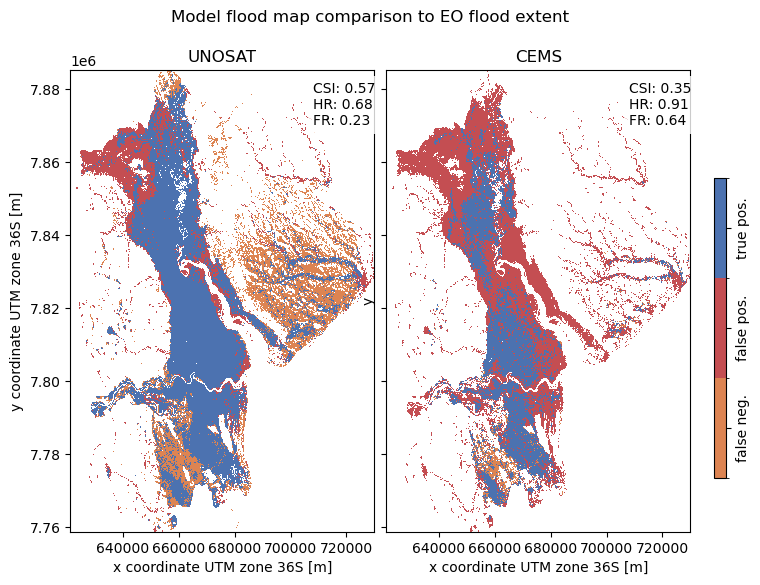

In [19]:
# Plot with validation metrics
source_list = [x.replace('obs_','') for x in list(ds.keys()) if 'obs' in x]

fig, axs = plt.subplots(
    figsize=(len(source_list)*4,6),
    nrows=1, ncols=len(source_list),
    #subplot_kw={'projection': sfincs_crs},
    sharex = True, sharey=True
)
if len(source_list) > 1: axs = axs.flatten()

for ii, source in enumerate(source_list):
    if len(source_list) > 1:
        ax=axs[ii]
    else: 
        ax=axs

    # Calculate skill
    da_skill, da_cm = skill(ds['model_clean'], ds[f'obs_{source}'], ds['sfincs_mask'], hmin=0.3)
    df_skill = da_skill.reset_coords(drop=True).to_dataframe()

    da_cm = da_cm.load()
    da_skill = da_skill.load()
    hr, csi, fr = np.round(da_skill['H'].item(),2), np.round(da_skill['C'].item(),2), np.round(da_skill['F'].item(),2)
    cs = da_cm.where(da_cm>0).plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
    ax.set_title(f'{source.upper()}')
    ax.text(0.8, 0.88, f'CSI: {csi:.2f}\nHR: {hr:.2f}\nFR: {fr:.2f}', transform=ax.transAxes, bbox=props)

    if ii==0:
        ax.yaxis.set_visible(True)
        ax.set_ylabel(f"y coordinate UTM zone {sfincs_utm} [m]")

    ax.xaxis.set_visible(True)
    ax.set_xlabel(f"x coordinate UTM zone {sfincs_utm} [m]")  

fig.subplots_adjust(wspace=0.04, hspace=0.06)
fig.suptitle('Model flood map comparison to EO flood extent')

# # Add a colorbar axis 
cbar_ax = fig.add_axes([0.93, 0.2, 0.015, 0.5])

# # Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='vertical', ticks=ticks)
cbar_ax.set_yticklabels(ticklabs, va='center', rotation=90)

Author:  
Natalia Aleksandrova (Deltares)
